# Sebelum mbgd

### Rule of thumb

* matriks/vektor selain y_predict tidak perlu disimpan

In [2]:
import numpy as np
import sys
from pytictoc import TicToc

class ActivationFunction:
    def __init__(self):
        pass
    
    def tanh(z):
        return np.tanh(z)
    
    def dtanh(z):
        return 1 - z**2

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    def dsigmoid(z):
        return z * (1 - z)

    def softmax(z):
        T,K = z.shape[0], z.shape[1]

        A = np.zeros((T,K))

        for t in range(T):
            row_sum = np.sum([np.exp(x) for x in z[t,:]])
            for k in range(K):
                A[t,k] = np.exp(z[t,k]) / row_sum

        return A
    
    def dsoftmax(z):
        return z * (1 - z)

class Optimizer:
    def __init__(self):
        pass

    def grad_descent(self, A, y):
        T = self.num_observation
        K = self.num_feature
        
        e   = y - self.y_predict
        one = np.ones((1,T))

        # hitung delta
        delta = [None for i in range(self.banyak_layer)]
        delta[-1] = -e / T
        for i in range(self.banyak_layer - 2, 0, -1):  # iterasi mundur
            delta[i] = delta[i+1] @ self.W[i].T * getattr(ActivationFunction, 'd'+self.activation[i])(A[i])
        
        # koreksi W and b
        for i in range(self.banyak_layer - 2, -1, -1):
            self.W[i] -= self.learning_rate * A[i].T @ delta[i+1]
            self.b[i] -= self.learning_rate * one @ delta[i+1]
            
class Layers:
    def __init__(self, neurons, activation, input_shape=None):
        self.neurons     = neurons
        self.activation  = activation
        self.input_shape = input_shape

class CostFunction:
    def __init__(self):
        pass
    
    def mse(self, dictionary):
        if dictionary == self.history:
            y         = self.train_label
            y_predict = self.y_predict
        elif dictionary == self.val_history:
            y         = self.y_val
            y_predict = self.forward(self.x_val)[-1]
        
        return 1/2 * np.sum((y - y_predict)**2)
    
    def cross_entropy(self, dictionary):
        if dictionary == self.history:
            y         = self.train_label
            y_predict = self.y_predict
        elif dictionary == self.val_history:
            y         = self.y_val
            y_predict = self.forward(self.x_val)[-1]
        
        T = y.shape[0]
        
        return -1/T * np.sum(y * np.log(y_predict) + (1 - y) * np.log(1 - y_predict))

class NeuralNetwork(Optimizer, CostFunction):
    def __init__(self):
        """
        Daftar layer berisi informasi semua layer: jumlah neuron dan fungsi aktivasi
        Elemen pertama daftar layer akan dikosongkan karena berkaitan dengan input layer
        """
        
        self.daftar_layer = [None]           
    
    def add_layer(self, layer):
        """Digunakan untuk menambahkan layer"""
        
        self.daftar_layer.append(layer)
    
    def compile(self, optimizer, loss_function):
        """Digunakan untuk menentukan optimizer dan cost function"""
        
        # memastikan loss function dan optimizer ada di pilihan
        assert optimizer in ['grad_descent']
        assert loss_function in ['mse', 'cross_entropy']
        
        self.optimizer     = optimizer
        self.loss_function = loss_function
    
    def forward(self, X):
        """
        Forward propagation
        Menghasilkan matriks A,
        bisa digunakan untuk backward propagation
        """
        
        Z = [None for i in range(self.banyak_layer)]
        A = [X] + [None for i in range(self.banyak_layer - 1)]
        
        for i in range(1, self.banyak_layer):
            Z[i] = A[i-1] @ self.W[i-1] + self.b[i-1]
            A[i] = getattr(ActivationFunction, self.activation[i])(Z[i])
        
        return A
    
    def backward(self, A, y):
        """Backward propagation"""
        
        if self.optimizer == "grad_descent":
            self.grad_descent(A, y)
            
    def add_training_time(self, dictionary):
        time = self.timer.tocvalue(restart=True)
        time = "{:.2f}".format(time)
        dictionary['training_time'].append(time)
        
    def add_accuracy(self, dictionary):
        if dictionary == self.history:
            y         = self.train_label
            y_predict = self.y_predict
        elif dictionary == self.val_history:
            y         = self.y_val
            y_predict = self.forward(self.x_val)[-1]
            
        jawaban = np.argmax(y_predict, axis=1)
        kunci_jawaban = np.argmax(y, axis=1)
        periksa = (jawaban == kunci_jawaban).astype('int8')
        accuracy = np.sum(periksa) / len(y)
        dictionary['accuracy'].append(accuracy)
        
    def add_loss(self, dictionary):
        loss = getattr(CostFunction, self.loss_function)(self, dictionary)
        dictionary['loss'].append(loss)
           
    def show_training_time(self):
        time = self.history['training_time'][-1] # mengambil waktu training yang terakhir ditambahkan
        print(f"training time: {time}s - ", end='')
        
    def show_loss(self):
        formatter = "{:.4f}"
        loss = self.history['loss'][-1] # mengambil loss yang terakhir ditambahkan
        print("loss: ", end='')
        if loss < 10:
            print(' ', end='')
        print(formatter.format(loss), end='')
        print(' - ', end='')
        
    def show_accuracy(self):
        formatter = "{:.4f}"
        accuracy = self.history['accuracy'][-1] # mengambil akurasi yang terakhir ditambahkan
        print("accuracy:", formatter.format(accuracy))
        
    def result_without_progress_bar(self, i):
        epoch = self.epoch
        if epoch >= 10:
            if i == epoch-1 or (i+1)%(epoch/5) == 0:
                print(f"Epoch {i+1}/{epoch}")
                self.show_training_time() # training time
                self.show_loss()          # loss
                self.show_accuracy()      # accuracy
        else:
            print(f"Epoch {i+1}/{epoch}")
            self.show_training_time()    # training time
            self.show_loss()             # loss
            self.show_accuracy()         # accuracy
        
    def result_with_progress_bar(self, i):
        epoch = self.epoch
        time = self.history['training_time'][-1]
        loss = self.history['loss'][-1]
        accuracy = self.history['accuracy'][-1]
        
        formatter = "{:.4f}"
        
        sys.stdout.write(
            '\r'
            + 'Epoch ' + str(i+1) + '/' + str(epoch) + (len(str(epoch))-len(str(i+1)))*' ' + ' - '
            + 'training time: ' + time + 's - '
            + 'loss: '+ formatter.format(loss) + ' - '
            + 'accuracy: ' + formatter.format(accuracy)
        )
        
        if i == epoch-1 or (i+1)%(epoch/5) == 0:
            print()
            
    def evaluate(self, test_data, test_label, cost=False, result=False):
        """Untuk mengukur akurasi model terhadap data di luar training data"""
        
        A = self.forward(test_data)
        y_predict = A[-1]
        
        jawaban = np.argmax(y_predict, axis=1)
        kunci_jawaban = np.argmax(test_label, axis=1)
        periksa = (jawaban == kunci_jawaban).astype('int8')
        accuracy = np.sum(periksa) / len(test_data)
        
        out = [accuracy]
        if cost:
            cost_value = getattr(CostFunction, self.loss_function)(self, self.val_history)
            out.append(cost_value)
        if result:
            out.append(jawaban)
        
        if not(cost or result):
            out = accuracy
            
        return out
    
    def train(self, input, output, learning_rate, epoch, x_val=None, y_val=None):
        
        """Apakah menggunakan validasi data?"""
        assert type(x_val) == type(y_val), "Periksa data validasi!"
        if type(x_val) == type(np.array(1)):
            self.validate = True
            
            self.x_val = x_val
            self.y_val = y_val
        else:
            self.validate = False
        
        """Deskripsi data dan model"""
        
        # Data utama murni hasil input
        # gak diapa-apain
        # jangan dipakai untuk training
        self.train_data  = input
        self.train_label = output
        
        # banyaknya baris dan kolom dari data
        self.num_observation = self.train_data.shape[0]
        self.num_feature     = self.train_data.shape[1]
        
        # learning rate dan epoch
        self.learning_rate = learning_rate
        self.epoch         = epoch
        
        self.banyak_layer = len(self.daftar_layer)
        self.neurons      = [self.num_feature] + [self.daftar_layer[i].neurons for i in range(1, self.banyak_layer)]
        self.activation   = [None] + [self.daftar_layer[i].activation for i in range(1, self.banyak_layer)]
        """"""
        
        """Parameter"""
        
        # Random Seed
        np.random.seed(10118096)
        
        self.W = [np.random.randn(self.neurons[i], self.neurons[i+1]) for i in range(len(self.neurons) - 1)] + [None]  # weights
        self.b = [np.random.randn(1, self.neurons[i]) for i in range(1, len(self.neurons))] + [None]                   # bias
        self.Z = [None for i in range(self.banyak_layer)]
        self.A = [self.train_data] + [None for i in range(self.banyak_layer - 1)]
        """"""
        
        """Rangkuman hasil training"""
        self.history = {'training_time' : [], 'loss' : [], 'accuracy' : []}
        
        # jika perlu melakukan validasi, perlu menambahkan tabel histori khusus
        if self.validate:
            self.val_history = {'training_time' : [], 'loss' : [], 'accuracy' : []}
        """"""
        
        self.timer = TicToc()
        self.timer.tic() # start timer
        
        """Untuk training"""
        X = self.train_data
        y = self.train_label
        
        for i in range(epoch):
            
            A = self.forward(X)
            self.y_predict = A[-1]
            
            """Update history"""
            self.add_training_time(self.history) # mencatat waktu training satu epoch
            self.add_accuracy(self.history)      # mencatat akurasi setelah satu epoch
            self.add_loss(self.history)          # mencatat loss setelah satu epoch
            """"""
            
            if self.validate:
                [val_accuracy, val_cost] = self.evaluate(x_val, y_val, cost=True)
                self.add_training_time(self.val_history) # mencatat waktu training satu epoch
                self.add_accuracy(self.val_history)      # mencatat akurasi setelah satu epoch
                self.add_loss(self.val_history)          # mencatat loss setelah satu epoch
            
            self.result_with_progress_bar(i) # menampilkan hasil training
            
            """Perbaiki model"""
            self.backward(A, y)
            
        """Hitung total waktu training"""        
        self.total_training_time = sum([float(time) for time in self.history['training_time']])
        
        """Mengubah data history menjadi dataframe"""
        self.history = pd.DataFrame(data=self.history).round(2)
        self.history.index += 1 # indeks dimulai dari 1
    
    def show_graph(self, graph):
        if graph in ['loss', 'training_loss']:
            graph = 'loss'
            title = 'Loss'
        elif graph in ['accuracy', 'training_accuracy']:
            graph = 'accuracy'
            title = 'Accuracy'
            
        epoch = range(1, self.epoch + 1)
        plt.plot(epoch, self.history[graph], label='training')
        
        if self.validate:
            plt.plot(epoch, self.val_history[graph], label='validation')
            plt.legend()
        
        plt.title(title)
        plt.xlabel('epoch')
        plt.ylabel(graph)
        plt.show()

In [18]:
AA = np.arange(20)
np.random.shuffle(AA)

In [14]:
BB = np.arange(50)
# BB = np.random.shuffle(BB)
BB

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [16]:
BB.ndim

1

# Klasifikasi angka

## Program

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data (28x28)

## Data (8x8)

In [58]:
import pandas as pd

df = pd.read_table('optdigits.tes',sep=',')

train_images = df.drop(columns=['0.29']).to_numpy().reshape(1796, 8, 8)
train_labels = df[['0.29']].to_numpy().T[0]

## Tampilan data

In [59]:
print("Shape train_images :", train_images.shape)
print("Shape train_labels :", train_labels.shape)

Shape train_images : (1796, 8, 8)
Shape train_labels : (1796,)


## Create network

In [64]:
"""Import module"""

# from ipynb.fs.full.neural_network import *

# import sys
# sys.path.append(".")
# from neural_network import *

"""Instantiation"""
network = NeuralNetwork()

"""Adding layers"""
network.add_layer(Layers(128, activation='sigmoid', input_shape=28*28))  # layer 1
network.add_layer(Layers(128, activation='sigmoid'))                     # Layer 2
network.add_layer(Layers(10, activation='softmax'))                      # Layer 3 atau output layer

"""Define optimizer and cost function"""
network.compile(optimizer='grad_descent', loss_function='cross_entropy')

## Training

In [66]:
X = train_images.reshape(train_images.shape[0], -1).astype('float32')
y = pd.get_dummies(train_labels).to_numpy().astype('float32')         # one hot encoding

# train data
X_train = X[:1600]
y_train = y[:1600]

# test data
X_test = X[1600:]
y_test = y[1600:]

network.train(X_train, y_train, learning_rate=1, epoch=100, x_val=X_test, y_val=y_test)

Epoch 20/100  - training time: 0.08s - loss: 1.1411 - accuracy: 0.78810
Epoch 40/100  - training time: 0.08s - loss: 0.2839 - accuracy: 0.9563
Epoch 60/100  - training time: 0.09s - loss: 0.1844 - accuracy: 0.9825
Epoch 80/100  - training time: 0.09s - loss: 0.1387 - accuracy: 0.9888
Epoch 100/100 - training time: 0.08s - loss: 0.1100 - accuracy: 0.9938


In [71]:
X.shape

(1796, 64)

In [67]:
print(f'Total waktu training: {"{:.2f}".format(network.total_training_time)}s')

accuracy = 100*network.history['accuracy'][network.epoch]
print(f'Akurasi: {"{:.2f}".format(accuracy)}%')

Total waktu training: 8.64s
Akurasi: 99.00%


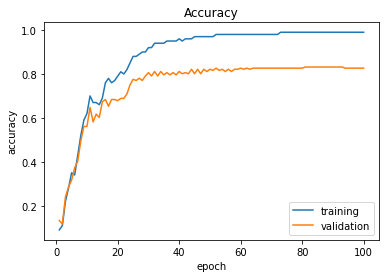

In [68]:
network.show_graph('accuracy')

In [69]:
accuracy = 100*network.evaluate(X_test, y_test)
print(f'Akurasi tes: {"{:.2f}".format(accuracy)}%')

Akurasi tes: 83.16%


# Klasifikasi pakaian

## Program

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print("Shape train_images :", train_images.shape)
print("Shape train_labels :", train_labels.shape)
print("train_labels : ", train_labels)

# train_images adalah data yang ingin dipelajari
# terdapat 60000 gambar hitam putih dengan ukuran 28x28 pixel dengan nilai pada interval [0,255]
# proses deep learning adalah mengidentifikasi nilai angka dari handwritten digit

## Pemilihan data untuk training

## Tampilan data

In [ ]:
# tampilkan gambar

def show_image(index):
    digit = train_images[index]
    plt.imshow(digit, cmap=plt.cm.binary)
    plt.show()

## Create network (1)

In [ ]:
"""Import module"""

# from ipynb.fs.full.neural_network import *

# import sys
# sys.path.append(".")
# from neural_network import *

"""Instantiation"""
network = NeuralNetwork()

"""Adding layers"""
network.add(Layers(256, activation='sigmoid', input_shape=28*28)) # layer 1
network.add(Layers(128, activation='sigmoid'))                    # Layer 2
network.add(Layers(10, activation='softmax'))                     # Layer 3 atau output layer

"""Define optimizer and cost function"""
network.compile(optimizer='grad_descent', loss='cross_entropy')

## Training

In [ ]:
X = train_images.reshape(train_images.shape[0], -1).astype('float32')
y = pd.get_dummies(train_labels).to_numpy().astype('float32')

alpha = 1
epochs = 250

network.train(X, y, alpha, epochs)

In [ ]:
print(f'Total waktu training: {"{:.2f}".format(network.total_training_time)}s')

accuracy = 100*network.accuracy
print(f'Akurasi: {"{:.2f}".format(accuracy)}%')

In [ ]:
epochs = range(1, len(network.history['loss']) + 1)
plt.plot(epochs, network.history['loss'])
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

epochs = range(1, len(network.history['accuracy']) + 1)
plt.plot(epochs, network.history['accuracy'])
plt.title("Training accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()